## Import necessary modules

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.utils import simple_tokenize
from gensim.parsing.preprocessing import strip_punctuation
from gensim.utils import tokenize
from gensim.parsing.preprocessing import preprocess_string
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Convert Raw data to structured Data

### 1. Corpus

In [ ]:
path = "/content/drive/MyDrive/Google Colab/cran/cran.all.1400"
file = open("/content/drive/MyDrive/Google Colab/cran/cran.all.1400", "r")
corpus = file.read()
file.close()
Documents = corpus.split(".I")
Documents = Documents[1:]
docs = []
for i in Documents:
    split = i.split(sep=".T", maxsplit=1)
    item = split[0]
    split = split[1].split(sep = ".A",maxsplit=1)
    title = split[0]
    split = split[1].split(sep = ".B",maxsplit=1)
    author = split[0]
    split = split[1].split(sep = ".W",maxsplit=1)
    bibliography = split[0]
    abstract = split[1]
    docs.append([item, title, author, bibliography, abstract])

In [ ]:
columns = ["item", "title", "author", "bibliography", "abstract"]
df_documents = pd.DataFrame(data = docs, columns = columns)

### 2. Queries

In [ ]:
PATH = "/content/drive/MyDrive/Google Colab/cran/cran.qry"
file = open(PATH, "r")
corpus = file.read()

In [ ]:
Queries = corpus.split(".I ")
Queries = Queries[1:]
queries = []
for i in Queries:
    split = i.split(sep=".W", maxsplit=1)
    query_number = split[0]
    query = split[1]
    queries.append([query_number, query])

In [ ]:
columns = ["item number", "query"]
df_queries = pd.DataFrame(data = queries, columns = columns)

In [ ]:
df_queries.head(10)

,item number,query
0,001\n,\nwhat similarity laws must be obeyed when con...
1,002\n,\nwhat are the structural and aeroelastic prob...
2,004\n,\nwhat problems of heat conduction in composit...
3,008\n,\ncan a criterion be developed to show empiric...
4,009\n,\nwhat chemical kinetic system is applicable t...
5,010\n,\nwhat theoretical and experimental guides do ...
6,012\n,\nis it possible to relate the available press...
7,013\n,\nwhat methods -dash exact or approximate -das...
8,015\n,\npapers on internal /slip flow/ heat transfer...
9,018\n,\nare real-gas transport properties for air av...


### 3.relevance judgements

In [ ]:
PATH = "/content/drive/MyDrive/Google Colab/cran/cranqrel"
df_relevant = pd.read_csv(PATH, sep='\s', usecols=[0, 1], names = ["query_id", "doc_id"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
df_relevant.head(10)

,query_id,doc_id
0,1,184
1,1,29
2,1,31
3,1,12
4,1,51
5,1,102
6,1,13
7,1,14
8,1,15
9,1,57


## Preprocessing Data

#### 1. Corpus




In [ ]:
docs = df_documents["abstract"].tolist()

In [ ]:
porter = PorterStemmer()
split_docs = []
for i in range(0,len(docs)):
  tokens = word_tokenize(docs[i])
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  stemmed = [porter.stem(word) for word in words]
  split_docs.append(stemmed)

### 1. Queries

In [ ]:
queries = df_queries["query"].tolist()

In [ ]:
porter = PorterStemmer()
split_queries = []
for i in range(0,len(queries)):
  tokens = word_tokenize(queries[i])
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  stemmed = [porter.stem(word) for word in words]
  split_queries.append(stemmed)

##  Documents index

### 1. Word Embedding: Word2Vec

In [ ]:
w2v_model = Word2Vec(split_docs, size=64, min_count=2,window=5, sg=1,workers=4)

In [ ]:
print('Vocabulary size:', len(w2v_model.wv.vocab))

Vocabulary size: 3339


### 2. Indexer

In [ ]:
matrix_docs = np.zeros((1400,300))

In [ ]:
# for i in range(0,1400):
#   j = 0
#   for term in split_docs[i]:
#     try:
#       matrix_docs[i] = matrix_docs[i] + w2v_model.wv.get_vector(term)
#     except KeyError:
#       j = j + 1
#   if len(split_docs[i]) -j  != 0:
#     matrix_docs[i] = np.true_divide(matrix_docs[i], len(split_docs[i]) - j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
 embeddings = []
 for i in range(0,1400):
  j = 0
  for term in split_docs[i]:
    if term in w2v_model.wv.vocab:
      embeddings.append(w2v_model.wv.word_vec(term))
    else:
      embeddings.append(np.random.rand(300))
  matrix_docs[i] = np.mean(embeddings, axis=0)

## Use IR system

### 1. Fetch relevant documents of queries

In [ ]:
# matrix_query = np.zeros((225,300))
# vector = np.zeros((300))
# for i in range(0,225):
#   j = 0
#   for term in stemmed:
#       try:
#         vector = vector + w2v_model.wv.get_vector(term)
#       except KeyError:
#         j = j + 1
#   vector = vector / (len(stemmed) - j)
#   matrix_query[i] = vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [ ]:
matrix_query = np.zeros((225,300))
embeddings = []
for i in range(0,225):
  j = 0
  for term in split_queries[i]:
    if term in w2v_model.wv.vocab:
      embeddings.append(w2v_model.wv.word_vec(term))
    else:
      embeddings.append(np.random.rand(300))
  matrix_query[i] =  np.mean(embeddings, axis=0)

In [ ]:
for i in range(0, 225):
  similarity = cosine_similarity(matrix_docs, matrix_query[i].reshape(1,-1))
  print(df_documents.loc[np.where(similarity >= 0.75)[0]])
  break

         item  ...                                           abstract
192     193\n  ...  \na study of inviscid flow about air foils at ...
747     748\n  ...  \nsubsonic aerodynamic flutter derivatives for...
793     794\n  ...  \nexperiments with a tapered swept-back wing o...
915     916\n  ...  \nthe flow around oscillating low aspect ratio...
970     971\n  ...  \nsurface pressure distributions with a sonic ...
1187   1188\n  ...  \nfactors affecting lift-drag ratios at mach n...
1337   1338\n  ...  \ninvestigation to determine effects of center...
1340   1341\n  ...  \ninvestigation of wing flutter at transonic s...
1379   1380\n  ...  \nthe problem of obtaining high lift-drag rati...

[9 rows x 5 columns]


In [ ]:
similarity.shape

(1400, 1)

In [ ]:
df_documents.loc[np.where(similarity >= 0.75)[0]]

,item,title,author,bibliography,abstract
708,709\n,\nstatic longitudinal aerodynamic characterist...,"\nolstad, w.b.\n","\nnasa tm x-610, 1961 .\n",\nstatic longitudinal aerodynamic characterist...
712,713\n,\nstatic longitudinal stability characteristic...,"\nmayo, e.e.\n",\nnasa tm x-222. 1959 .\n,\nstatic longitudinal stability characteristic...
779,780\n,\nthe transonic characteristics of 38 cambered...,"\nnelson,w.h. and krumm,w.j.\n","\nnaca tn.3502, 1955.\n",\nthe transonic characteristics of 38 cambered...
1291,1292\n,\neffect of jet pluming on the static stabilit...,"\nhinson,w.f. and falanga,r.a.\n","\nnasa tn.d1352, 1962.\n",\neffect of jet pluming on the static stabilit...
1337,1338\n,\ninvestigation to determine effects of center...,"\njones, g.w. and unangst, j.r.\n","\nnaca rm l55k30, 1956 .\n",\ninvestigation to determine effects of center...
1340,1341\n,\ninvestigation of wing flutter at transonic s...,"\njones, g.w. and dubose, h.c.\n","\nnaca rml53g10a, 1953 .\n",\ninvestigation of wing flutter at transonic s...
1348,1349\n,\neffects of simulated rocket jet exhaust on s...,"\nfetterman,d.e.\n","\nnasa tm.x127, 1959.\n",\neffects of simulated rocket jet exhaust on s...
1379,1380\n,\nthe problem of obtaining high lift-drag rati...,\nclinton e. brown and francis e. mclean\n,"\nlangley research center, nasa\n",\nthe problem of obtaining high lift-drag rati...


### 2. Evaluate IR system

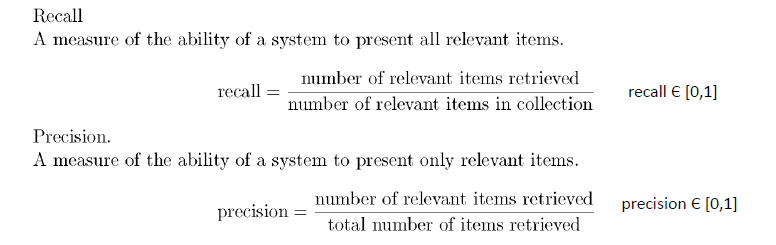

* Recall and Precision metric


1.   Method 1






In [ ]:
metrics = []
for i in range(1, 226):
  similarity = cosine_similarity(matrix_docs, matrix_query[i - 1].reshape(1,-1))
  item_retrieved = [i.rstrip("\n").lstrip(" ") for i in df_documents.loc[np.where(similarity >= 0.5)[0]]["item"].to_list()]
  relevant_items_in_collection = df_relevant[df_relevant["query_id"] == i]
  nb_of_relevant_items_in_collection = relevant_items_in_collection.count()[0]
  nb_of_items_retrieved = len(item_retrieved)
  nb_relevant_items_retrieved = 0
  for j in item_retrieved:
    if int(j) in relevant_items_in_collection['doc_id'].to_list():
      nb_relevant_items_retrieved += 1
  recall = nb_relevant_items_retrieved / nb_of_relevant_items_in_collection
  precison = 0 if nb_of_items_retrieved == 0 else nb_relevant_items_retrieved / nb_of_items_retrieved
  metrics.append([i, recall, precison])
columns = ["Items", "Recall", "Precison"]
df_metrics = pd.DataFrame(metrics,columns = columns)

*   Method 2



In [ ]:
metrics = []
for i in range(1, 226):
  similarity = cosine_similarity(matrix_docs, matrix_query[i - 1].reshape(1,-1))
  np.argsort(similarity.flatten())[1399:1369:-1]
  item_retrieved = [i.rstrip("\n").lstrip(" ") for i in df_documents.loc[np.argsort(similarity.flatten())[1399:1379:-1]]["item"].to_list()]
  relevant_items_in_collection = df_relevant[df_relevant["query_id"] == i]
  nb_of_relevant_items_in_collection = relevant_items_in_collection.count()[0]
  nb_of_items_retrieved = len(item_retrieved)
  nb_relevant_items_retrieved = 0
  for j in item_retrieved:
    if int(j) in relevant_items_in_collection['doc_id'].to_list():
      nb_relevant_items_retrieved += 1
  recall = nb_relevant_items_retrieved / nb_of_relevant_items_in_collection
  precison = 0 if nb_of_items_retrieved == 0 else nb_relevant_items_retrieved / nb_of_items_retrieved
  metrics.append([i, recall, precison])
columns = ["Items", "Recall", "Precison"]
df_metrics = pd.DataFrame(metrics,columns = columns)

In [ ]:
df_metrics

,Items,Recall,Precison
0,1,0.00,0.00
1,2,0.00,0.00
2,3,0.00,0.00
3,4,0.00,0.00
4,5,0.00,0.00
...,...,...,...
220,221,0.00,0.00
221,222,0.00,0.00
222,223,0.00,0.00
223,224,0.00,0.00


In [ ]:
#split_docs = []
#for doc in docs:
#  split_docs.append(doc.split())

In [ ]:
#for i in range(0,len(docs)):
#  docs[i] = remove_stopwords(docs[i])
#  docs[i] = strip_non_alphanum(docs[i])
#  docs[i] = strip_multiple_whitespaces(docs[i])
#  docs[i] = stem_text(docs[i])

In [ ]:
#x = np.argsort(similarity.flatten())
#y = x[1399:1379:-1]
#similarity[np.where(similarity > 0.975)]


#split_Query = Query.split()